# <center>**cs512 f24 - assignment 5 (vision transformer)**</center>

### <div style="text-align: right"> Seonghwan Lim &nbsp;&nbsp; </div>
### <div style="text-align: right"> A20586593 &nbsp;&nbsp; </div>

### **Tasks:**

In [1]:
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from transformers import ViTConfig, ViTModel

# Device configuration: use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\qube2\anaconda3\envs\cs512\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### **1. Dataset Preparation**

In [2]:
# Define data transformation: Resize images to 224x224 and convert to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load CIFAR10 dataset with the defined transformation
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the number of samples per class for each split
num_classes = 10
samples_per_class = 4000 // num_classes  # Total samples per class
train_val_per_class = 3000 // num_classes  # Train + Validation samples per class
test_per_class = 1000 // num_classes  # Test samples per class

# Group indices by class
class_indices = {i: [] for i in range(num_classes)}
for idx, (_, label) in enumerate(dataset):
    class_indices[label].append(idx)

# Split indices into training/validation and test sets
train_val_indices = []
test_indices = []
for cls, indices in class_indices.items():
    np.random.shuffle(indices)  # Shuffle indices for randomness
    train_val_indices.extend(indices[:train_val_per_class])
    test_indices.extend(indices[train_val_per_class:train_val_per_class + test_per_class])

# Further split training/validation indices into separate train and validation sets
train_indices = []
val_indices = []
train_ratio = 0.9  # Split ratio: Train 90%, Validation 10%
for cls in range(num_classes):
    cls_indices = [idx for idx in train_val_indices if dataset[idx][1] == cls]
    split_point = int(len(cls_indices) * train_ratio)
    train_indices.extend(cls_indices[:split_point])
    val_indices.extend(cls_indices[split_point:])

# Create subsets for train, validation, and test data
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

# Define DataLoaders for each subset
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Function to print class distribution in a DataLoader
def print_class_distribution(dataloader, name):
    targets = [dataset[idx][1] for idx in dataloader.dataset.indices]
    class_counts = Counter(targets)
    print(f"{name} class distribution: {class_counts}")

# Print dataset sizes and class distributions
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(valid_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

print_class_distribution(train_loader, "Train")
print_class_distribution(valid_loader, "Validation")
print_class_distribution(test_loader, "Test")

Files already downloaded and verified
Train size: 2700
Validation size: 300
Test size: 1000
Train class distribution: Counter({0: 270, 1: 270, 2: 270, 3: 270, 4: 270, 5: 270, 6: 270, 7: 270, 8: 270, 9: 270})
Validation class distribution: Counter({0: 30, 1: 30, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30, 7: 30, 8: 30, 9: 30})
Test class distribution: Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100})


#### **2. Standard Vision Transformer (ViT) Model**

In [3]:
# Configure the Vision Transformer (ViT) model
vit_config = ViTConfig(
    image_size=224,
    patch_size=16,
    num_channels=3,
    num_labels=10
)

# Load a pretrained ViT model from Hugging Face's transformers library
vit = ViTModel.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    config=vit_config,
    ignore_mismatched_sizes=True
)

# Define a custom ViT-based model with an added classification head
class ViT(nn.Module):
    def __init__(self, vit_model, num_classes):
        super().__init__()
        self.vit = vit_model  # Pretrained ViT model
        # Add a classification head with the number of output classes
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        # Pass input through the ViT model and get the last hidden state
        vit_outputs = self.vit(x).last_hidden_state
        # Extract the CLS token (first token) for classification
        cls_token = vit_outputs[:, 0]
        # Pass the CLS token through the classification head
        return self.classifier(cls_token)

#### **3. Hybrid VGG16 + ViT Model**

In [10]:
# Define VGG16 Feature Extractor
class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the pretrained VGG16 model with weights trained on ImageNet
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        # Extract features up to block5_conv3 (layer 30)
        self.feature_extractor = vgg16.features[:30]
        # Freeze parameters to use it as a fixed feature extractor
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Forward pass through the feature extractor
        return self.feature_extractor(x)  # Output shape: [B, 512, 14, 14]

# Initialize the VGG16 feature extractor
vgg_extractor = VGG16FeatureExtractor().to(device)

# Configure the Vision Transformer (ViT) to process VGG16 output
hybrid_vit_config = ViTConfig(
    image_size=14,
    patch_size=1,
    num_channels=512,
    num_labels=10
)

# Initialize the pretrained ViT model with the custom configuration
hybrid_vit = ViTModel.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    config=hybrid_vit_config,
    ignore_mismatched_sizes=True
)

# Define the hybrid VGG16 + ViT model
class VGG_ViT(nn.Module):
    def __init__(self, vgg_extractor, vit_model, num_classes):
        super().__init__()
        self.vgg_extractor = vgg_extractor  # VGG16 feature extractor
        self.vit = vit_model               # Pretrained ViT model
        # Classification head to map ViT outputs to the desired number of classes
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        # Step 1: Extract feature maps using VGG16
        features = self.vgg_extractor(x)  # Shape: [B, 512, 14, 14]

        # Step 2: Process feature maps through the ViT model
        vit_outputs = self.vit(features).last_hidden_state
        # Extract the CLS token for classification
        cls_token = vit_outputs[:, 0]

        # Step 3: Pass CLS token through the classification head
        return self.classifier(cls_token)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized because the shapes did not match:
- embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 512, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **4. Train and Evaluate**

In [5]:
# Function to train the model
def train_model(model, train_loader, valid_loader, optimizer, criterion, epochs=10, save_interval=2):
    # Initialize lists to store metrics
    train_acc, valid_acc = [], []
    train_loss, valid_loss = [], []
    train_f1, valid_f1 = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()  # Set model to training mode
        running_loss, correct, total = 0.0, 0, 0
        y_true_train, y_pred_train = [], []

        for inputs, targets in train_loader:
            # Move inputs and targets to the configured device
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update parameters

            # Accumulate training loss and correct predictions
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)  # Get predicted class
            correct += (preds == targets).sum().item()
            total += targets.size(0)

            # Collect predictions and true labels for F1 score computation
            y_true_train.extend(targets.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        # Calculate training metrics
        epoch_train_f1 = f1_score(y_true_train, y_pred_train, average="weighted")
        train_f1.append(epoch_train_f1)
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        valid_running_loss, valid_correct, valid_total = 0.0, 0, 0
        y_true_valid, y_pred_valid = [], []

        with torch.no_grad():
            for inputs, targets in valid_loader:
                # Move inputs and targets to the configured device
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)  # Compute loss
                valid_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)  # Get predicted class
                valid_correct += (preds == targets).sum().item()
                valid_total += targets.size(0)

                # Collect predictions and true labels for F1 score computation
                y_true_valid.extend(targets.cpu().numpy())
                y_pred_valid.extend(preds.cpu().numpy())

        # Calculate validation metrics
        epoch_valid_f1 = f1_score(y_true_valid, y_pred_valid, average="weighted")
        valid_f1.append(epoch_valid_f1)
        valid_loss.append(valid_running_loss / len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Train F1: {train_f1[-1]:.4f}, "
              f"Valid Loss: {valid_loss[-1]:.4f}, Valid Acc: {valid_acc[-1]:.4f}, Valid F1: {valid_f1[-1]:.4f}")

    # Return all metrics for analysis or plotting
    return train_loss, train_acc, valid_loss, valid_acc, train_f1, valid_f1

# Function to evaluate the model on the test dataset
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            # Move inputs and targets to the configured device
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predicted class
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate test accuracy and F1 score
    test_accuracy = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred, average="weighted")
    return test_accuracy, test_f1

#### **4.1. ViT Model**

In [6]:
# Initialize the custom ViT model and move it to the selected device (GPU/CPU)
vit_model = ViT(vit, num_classes=10).to(device)

# Define the optimizer for the ViT model
optimizer_vit = torch.optim.Adam(vit_model.parameters(), lr=1e-4)  # Learning rate set to 1e-4

# Define the loss function
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification

# Train the ViT-only model and track metrics
vit_train_loss, vit_train_acc, vit_valid_loss, vit_valid_acc, vit_train_f1, vit_valid_f1 = train_model(
    vit_model,
    train_loader,
    valid_loader,
    optimizer_vit,
    criterion,
    epochs=15
)

# Evaluate the trained ViT model on the test set
vit_test_accuracy, vit_test_f1 = evaluate_model(vit_model, test_loader)

# Print test results
print(f"ViT Only: Test Accuracy = {vit_test_accuracy:.4f}, F1 Score = {vit_test_f1:.4f}")

# Release GPU memory to optimize resource usage
del vit_model
del optimizer_vit
torch.cuda.empty_cache()
print("GPU memory for ViT model has been released.")

c:\Users\qube2\anaconda3\envs\cs512\lib\site-packages\transformers\models\vit\modeling_vit.py:277: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


Epoch 1/15: Train Loss: 1.0947, Train Acc: 0.8426, Train F1: 0.8449, Valid Loss: 0.4447, Valid Acc: 0.9300, Valid F1: 0.9303
Epoch 2/15: Train Loss: 0.2590, Train Acc: 0.9689, Train F1: 0.9689, Valid Loss: 0.3734, Valid Acc: 0.9100, Valid F1: 0.9100
Epoch 3/15: Train Loss: 0.1258, Train Acc: 0.9859, Train F1: 0.9859, Valid Loss: 0.3065, Valid Acc: 0.9133, Valid F1: 0.9120
Epoch 4/15: Train Loss: 0.1008, Train Acc: 0.9859, Train F1: 0.9859, Valid Loss: 0.3750, Valid Acc: 0.8833, Valid F1: 0.8830
Epoch 5/15: Train Loss: 0.1101, Train Acc: 0.9774, Train F1: 0.9774, Valid Loss: 0.2827, Valid Acc: 0.9267, Valid F1: 0.9273
Epoch 6/15: Train Loss: 0.0674, Train Acc: 0.9878, Train F1: 0.9878, Valid Loss: 0.3160, Valid Acc: 0.9133, Valid F1: 0.9140
Epoch 7/15: Train Loss: 0.0426, Train Acc: 0.9930, Train F1: 0.9930, Valid Loss: 0.4528, Valid Acc: 0.8767, Valid F1: 0.8760
Epoch 8/15: Train Loss: 0.0401, Train Acc: 0.9948, Train F1: 0.9948, Valid Loss: 0.2513, Valid Acc: 0.9367, Valid F1: 0.9360


#### **4.2. Hybrid VGG16 ViT Model**

In [11]:
# Initialize the hybrid VGG16 + ViT model
vgg_vit_model = VGG_ViT(vgg_extractor, hybrid_vit, num_classes=10).to(device)

# Define the optimizer for the Hybrid VGG16 + ViT model
# Only update parameters that require gradients (ViT and classifier layers)
optimizer_hybrid = torch.optim.Adam(
    filter(lambda p: p.requires_grad, vgg_vit_model.parameters()), 
    lr=1e-4  # Learning rate set to 1e-4
)

# Define the loss function
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification

# Train the Hybrid VGG16 + ViT model and track metrics
hybrid_train_loss, hybrid_train_acc, hybrid_valid_loss, hybrid_valid_acc, hybrid_train_f1, hybrid_valid_f1 = train_model(
    vgg_vit_model,
    train_loader,
    valid_loader,
    optimizer_hybrid,
    criterion,
    epochs=15
)

# Evaluate the trained Hybrid VGG16 + ViT model on the test set
hybrid_test_accuracy, hybrid_test_f1 = evaluate_model(vgg_vit_model, test_loader)

# Print the test results
print(f"Hybrid VGG16 + ViT: Test Accuracy = {hybrid_test_accuracy:.4f}, F1 Score = {hybrid_test_f1:.4f}")

# Release GPU memory to optimize resource usage
del vgg_vit_model
del optimizer_hybrid
torch.cuda.empty_cache()
print("GPU memory for Hybrid VGG16 + ViT model has been released.")

Epoch 1/15: Train Loss: 1.9732, Train Acc: 0.2807, Train F1: 0.2635, Valid Loss: 1.6627, Valid Acc: 0.3767, Valid F1: 0.3476
Epoch 2/15: Train Loss: 1.3657, Train Acc: 0.5448, Train F1: 0.5316, Valid Loss: 1.2780, Valid Acc: 0.5500, Valid F1: 0.5403
Epoch 3/15: Train Loss: 0.9911, Train Acc: 0.6856, Train F1: 0.6840, Valid Loss: 1.1947, Valid Acc: 0.5900, Valid F1: 0.5792
Epoch 4/15: Train Loss: 0.7886, Train Acc: 0.7570, Train F1: 0.7567, Valid Loss: 1.1517, Valid Acc: 0.5933, Valid F1: 0.5845
Epoch 5/15: Train Loss: 0.5449, Train Acc: 0.8400, Train F1: 0.8399, Valid Loss: 1.1005, Valid Acc: 0.6133, Valid F1: 0.6131
Epoch 6/15: Train Loss: 0.4044, Train Acc: 0.8856, Train F1: 0.8855, Valid Loss: 1.2019, Valid Acc: 0.6300, Valid F1: 0.6311
Epoch 7/15: Train Loss: 0.2967, Train Acc: 0.9204, Train F1: 0.9204, Valid Loss: 1.1635, Valid Acc: 0.6367, Valid F1: 0.6407
Epoch 8/15: Train Loss: 0.3229, Train Acc: 0.9041, Train F1: 0.9041, Valid Loss: 1.1892, Valid Acc: 0.6400, Valid F1: 0.6412


#### **5. Analysis and Comparison**

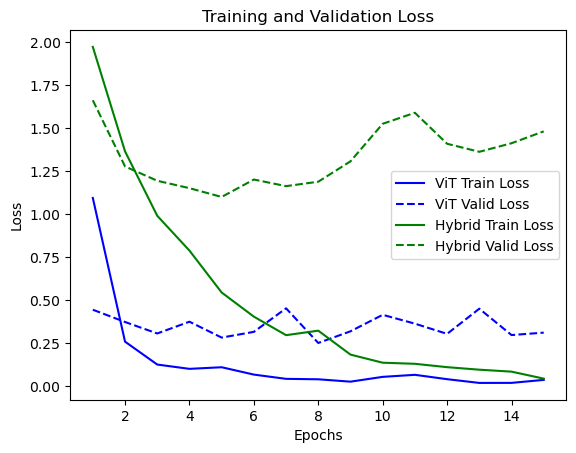

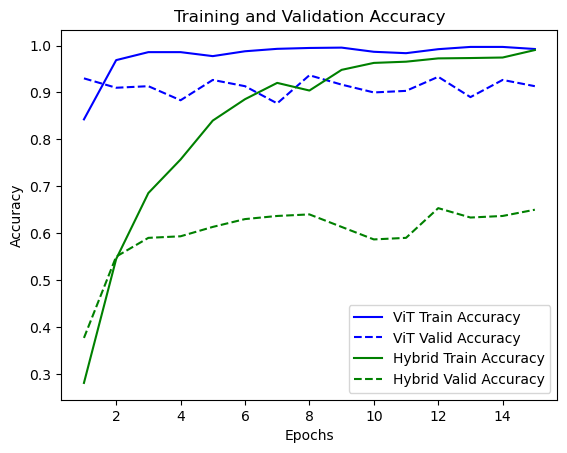

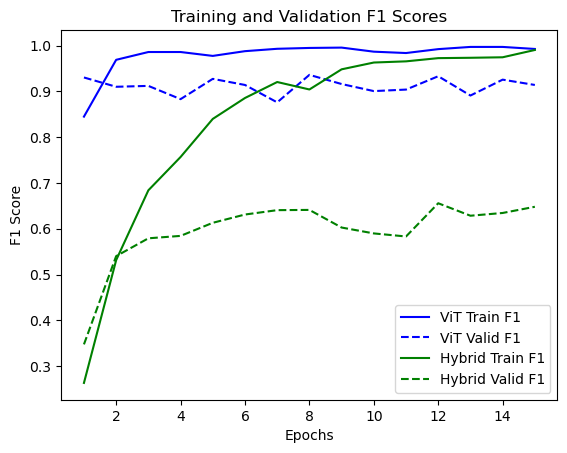

In [ ]:
# Define the range of epochs for plotting
epochs_range = range(1, 16)

# Plot comparison: Loss
plt.figure()
plt.plot(epochs_range, vit_train_loss, label="ViT Train Loss", color='blue', linestyle='-')
plt.plot(epochs_range, vit_valid_loss, label="ViT Valid Loss", color='blue', linestyle='--')
plt.plot(epochs_range, hybrid_train_loss, label="Hybrid Train Loss", color='green', linestyle='-')
plt.plot(epochs_range, hybrid_valid_loss, label="Hybrid Valid Loss", color='green', linestyle='--')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot comparison: Accuracy
plt.figure()
plt.plot(epochs_range, vit_train_acc, label="ViT Train Accuracy", color='blue', linestyle='-')
plt.plot(epochs_range, vit_valid_acc, label="ViT Valid Accuracy", color='blue', linestyle='--')
plt.plot(epochs_range, hybrid_train_acc, label="Hybrid Train Accuracy", color='green', linestyle='-')
plt.plot(epochs_range, hybrid_valid_acc, label="Hybrid Valid Accuracy", color='green', linestyle='--')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot comparison: F1 Scores
plt.figure()
plt.plot(epochs_range, vit_train_f1, label="ViT Train F1", color='blue', linestyle='-')
plt.plot(epochs_range, vit_valid_f1, label="ViT Valid F1", color='blue', linestyle='--')
plt.plot(epochs_range, hybrid_train_f1, label="Hybrid Train F1", color='green', linestyle='-')
plt.plot(epochs_range, hybrid_valid_f1, label="Hybrid Valid F1", color='green', linestyle='--')
plt.title("Training and Validation F1 Scores")  # Chart title
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

#### **5.1. Performance Analysis:**
**Model Comparison**:

ViT: Test Accuracy = 94.20%, F1 Score = 94.14%.

Hybrid: Test Accuracy = 64.60%, F1 Score = 64.27%.

**Training vs Validation**:

ViT showed stable and consistent performance with minimal overfitting.

Hybrid model overfitted, with large gaps between training and validation metrics.


#### **5.2. Discussion:**
**Key Insights**:
ViT's end-to-end design is better suited for learning representations.

The Hybrid model struggled due to reliance on frozen VGG16 layers, limiting adaptability.

**Trade-offs**:

ViT: High accuracy but computationally expensive.

Hybrid: Faster training but poor generalization.

**Improvements**:

Fine-tune VGG16 layers in the Hybrid model.

Use data augmentation and learning rate scheduling for both models to improve generalization.
